# Benchmark between Matlab and Python implementation of DEPSI spatial unwrapping

We will construct a network with pnts and arcs from matlab data.

The relevant data we are using from MATLAB are:

Inputs:
- arc ambiguities
- source and destination point indices for arcs
- point azimuth and range indices, order matters since it connects to arcs
- reference point id
- ref point azimuth and range

Outputs:
- point ambiguities

Now arc estimation happens in this process, so theoretically pnts and arcs phases should not matter.

In [1]:
import xarray as xr
import numpy as np
import scipy
import math
from matplotlib import pyplot as plt

# import matplotlib.cm as cm
import matplotlib.colors as plc

from depsi.network import (
    spatial_unwrapping,
    _network_relation_matrix,
)

WAVELENGTH = 0.055465763  # Sentinel-1, in meters

In [2]:
# Matlab files
file_mat_input = "../../data/marken_tsx_testdata_spatial_integration/marken_tsx_spatial_unwrapping_testdata_input.mat"
file_mat_output = "../../data/marken_tsx_testdata_spatial_integration/marken_tsx_spatial_unwrapping_testdata_output.mat"
data_input = scipy.io.loadmat(file_mat_input)
data_output = scipy.io.loadmat(file_mat_output)

In [3]:
data_input.keys()

dict_keys(['__header__', '__version__', '__globals__', 'atmo_range', 'defo_range', 'detail_plots', 'detrend_flag', 'fig', 'max_mem_buffer', 'orbit', 'ps_eval_method', 'sat_vel', 'visible_plots', 'ens_coh_threshold', 'varfac_threshold', 'ref_cn', 'Nifgs', 'Npsc', 'Npsc_selections', 'Nref', 'Narcs', 'Btemp', 'Bdop', 'final_model', 'std_param', 'sig2_est', 'breakpoint', 'breakpoint2', 'network_flag', 'z', 'final_althyp_index', 'removed_points_flag', 'ans', 'fid_res', 'project_id', 'fullscreen', 'Npixels', 'Nlines', 'minratio', 'ratio_index', 'figpos', 'separate_flag', 'dpsc_fid', 'dpsc_arcs', 'dpsc_phase', 'dpsc_h2ph', 'dpsc_results_fid', 'Npar_max', 'dpsc_param', 'dpsc_ens_coh', 'dpsc_acheck', 'dpsc_model_info', 'dpsc_varfac_best', 'psc_fid', 'psc_data', 'psc_array_in', 'psc_az', 'psc_r', 'psc_h2ph', 'ps_method', 'unwrap_istep', 'unwrap2_istep', 'results_id', 'az_spacing', 'r_spacing', 'weighted_unwrap', 'run_mode', 'defo_model_flag', 'weighting', 'm2ph'])

In [4]:
data_output.keys()

dict_keys(['__header__', '__version__', '__globals__', 'atmo_range', 'defo_range', 'detail_plots', 'detrend_flag', 'fig', 'max_mem_buffer', 'orbit', 'ps_eval_method', 'sat_vel', 'visible_plots', 'ens_coh_threshold', 'varfac_threshold', 'ref_cn', 'Nifgs', 'Npsc', 'Npsc_selections', 'Nref', 'Narcs', 'Btemp', 'Bdop', 'final_model', 'std_param', 'sig2_est', 'breakpoint', 'breakpoint2', 'network_flag', 'z', 'final_althyp_index', 'removed_points_flag', 'ans', 'fid_res', 'project_id', 'fullscreen', 'Npixels', 'Nlines', 'minratio', 'ratio_index', 'figpos', 'separate_flag', 'dpsc_fid', 'dpsc_arcs', 'dpsc_phase', 'dpsc_h2ph', 'dpsc_results_fid', 'Npar_max', 'dpsc_param', 'dpsc_ens_coh', 'dpsc_acheck', 'dpsc_model_info', 'dpsc_varfac_best', 'psc_fid', 'psc_data', 'psc_array_in', 'psc_az', 'psc_r', 'psc_h2ph', 'ps_method', 'low_coh', 'dpsc_arcs_removed1', 'dpsc_arcs_orig', 'Narcs_new', 'unwrap_istep', 'unwrap2_istep', 'exit_flag', 'dpsc_arcs_removed2', 'psc', 'Npsc_connections', 'v', 'index_cns', 

In [7]:
# Input data
azimuth_idx = data_input["psc_data"][:, 4] # azimuth index
range_idx = data_input["psc_data"][:, 5] # range index
Btemp = data_input["Btemp"].squeeze()
pnt_phase = data_input["psc_data"][:, 6:6+data_input["Btemp"].shape[0]]
pnt_h2ph = data_input["psc_data"][:,(6+data_input["Btemp"].shape[0]):(6+2*data_input["Btemp"].shape[0])]
arc_h2ph = data_input["dpsc_h2ph"] # arc h2ph values
arc_phases = data_input["dpsc_phase"] # arc phase values
arc_ens_coh = data_input["dpsc_ens_coh"].squeeze() # arc ensemble coherence
arc_acheck = data_input["dpsc_acheck"]
Narcs = data_input["Narcs"].squeeze()
idx_source = data_input["dpsc_arcs"][:, 0]-1 # MATLAB to Python index
idx_target = data_input["dpsc_arcs"][:, 1]-1 # MATLAB to Python index

# reference point, this is taken from output data
idx_ref_pnt = data_output["ref_array"][0][0] - 1 # MATLAB to Python index 
refpnt_azimuth = data_output["ref_array"][0][1]
refpnt_range = data_output["ref_array"][0][2]

# Processing parameters
ens_coh_threshold = data_input["ens_coh_threshold"][0][0] # arc selection threshold

In [8]:
print(f"quality threshold: {ens_coh_threshold}")

quality threshold: 0.5


In [9]:
print(f"reference point azimuth: {refpnt_azimuth}, range: {refpnt_range}")

reference point azimuth: 791, range: 850


In [10]:
# Assign ambiguity results to original points array
acheck = data_output["acheck"]
idx_nonref_pnts = data_output["non_ref_points"].squeeze()-1

### Validation 1: check the network constructed from MATLAB data, see if the souce and target points are correctly mapped.

In [11]:
# Points stm as xr dataset with space and time dimensions
stm = xr.Dataset(
    data_vars={
        "pnt_h2ph": (("space", "time"), pnt_h2ph),
        "pnt_phase": (("space", "time"), pnt_phase),
    },
    coords={
        "time": (("time"), Btemp),
        "space": (("space"), np.arange(azimuth_idx.shape[0])),
        "azimuth": (("space"), azimuth_idx),
        "range": (("space"), range_idx),
    },
)
stm

<xarray.Dataset> Size: 2MB
Dimensions:    (space: 271, time: 359)
Coordinates:
  * space      (space) int64 2kB 0 1 2 3 4 5 6 7 ... 264 265 266 267 268 269 270
  * time       (time) float64 3kB -8.167 -8.137 -8.107 ... 5.877 5.907 5.937
    azimuth    (space) float64 2kB 35.0 35.0 107.0 ... 2.051e+03 2.058e+03
    range      (space) float64 2kB 315.0 688.0 693.0 684.0 ... 384.0 460.0 579.0
Data variables:
    pnt_h2ph   (space, time) float64 778kB 0.001356 4.448e-05 ... -0.0002177
    pnt_phase  (space, time) float64 778kB 0.3294 -3.001 2.89 ... -2.475 1.463

In [12]:
# Manually assign a uid
scale = 10 ** (math.floor(math.log10(stm.sizes["space"])) + 1)  # Scale to ensure no overlap
uid = scale * (idx_source + 1) + (idx_target + 1)  # Plus one to avoid zero uid
uid = uid.astype(np.int64)

stm_arcs = xr.Dataset(
    data_vars={
        "h2ph": (("space", "time"), arc_h2ph),
        "ambiguities": (("space", "time"), arc_acheck),
        "ens_coh": (("space"), arc_ens_coh),
        "d_phase": (("space", "time"), arc_phases),
        "uid": (("space"), uid),
    },
    coords={
        "time": (("time"), Btemp),
        "source": (("space"), idx_source),
        "target": (("space"), idx_target),
    },
)
stm_arcs

<xarray.Dataset> Size: 7MB
Dimensions:      (space: 797, time: 359)
Coordinates:
  * time         (time) float64 3kB -8.167 -8.137 -8.107 ... 5.877 5.907 5.937
    source       (space) uint16 2kB 0 0 0 0 0 1 1 ... 266 266 267 267 268 269
    target       (space) uint16 2kB 1 2 3 6 14 2 4 ... 269 270 268 269 269 270
Dimensions without coordinates: space
Data variables:
    h2ph         (space, time) float64 2MB 0.001355 4.472e-05 ... -0.0002178
    ambiguities  (space, time) float64 2MB -17.0 -17.0 -16.0 ... -1.0 0.0 0.0
    ens_coh      (space) float64 6kB 0.1747 0.1696 0.163 ... 0.8257 0.8315
    d_phase      (space, time) float64 2MB 2.361 3.392 -5.502 ... -0.8651 -1.176
    uid          (space) int64 6kB 1002 1003 1004 1007 ... 6125 6126 7126 8127

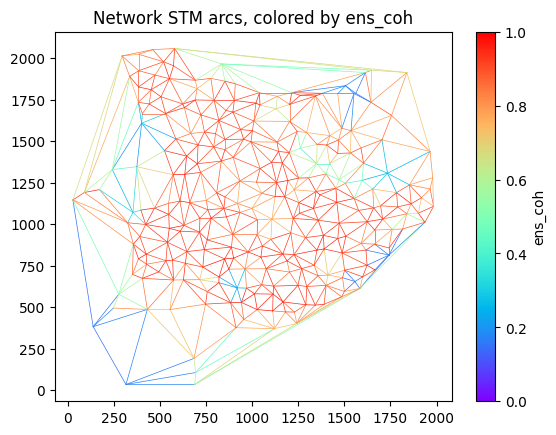

In [13]:
# x of sources and targets
xx = np.stack(
    [
        stm.isel(space=stm_arcs["source"])["range"].values,
        stm.isel(space=stm_arcs["target"])["range"].values,
    ]
).T
# y of sources and targets
yy = np.stack(
    [
        stm.isel(space=stm_arcs["source"])["azimuth"].values,
        stm.isel(space=stm_arcs["target"])["azimuth"].values,
    ]
).T
# Visualize created arcs
fig, ax = plt.subplots()
cmap = plt.cm.rainbow
norm = plc.Normalize(vmin=0, vmax=1.0)
mean_nmad = np.abs(stm_arcs["ens_coh"].data)
for i in range(stm_arcs.sizes["space"]):
    ax.plot(xx[i], yy[i], color=cmap(norm(mean_nmad[i])), linewidth=0.5)
plt.title("Network STM arcs, colored by ens_coh")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="ens_coh")

## Perform spatial unwrapping to compute point ambiguities from arc ambiguities

In [16]:
stm_arcs_output, stm_pnts_output = spatial_unwrapping(
    stm,
    stm_arcs,
    threshold_arc_quality=ens_coh_threshold,
    idx_refpnt=idx_ref_pnt,
    arc_estimation_method="periodogram",
    sparse_mode = False
)

/home/oku/Developments/MobyLe/DePSI_group/depsi/mht_utils.py:255: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  lambda_init = fsolve(lambda lambda_init: _lambda_approx(lambda_init, df, gam0, cv), lstrt)
INFO:depsi.network:MHT iteration 0: OMT=1.81e+04
INFO:depsi.network:MHT iteration 0: removing arc index 532 with TT1=3130.90
INFO:depsi.network:MHT iteration 1: OMT=9.59e+03
INFO:depsi.network:MHT iteration 1: removing arc index 476 with TT1=3007.72
INFO:depsi.network:MHT iteration 2: OMT=1.45e+03
INFO:depsi.network:MHT iteration 2: removing arc index 591 with TT1=264.48
INFO:depsi.network:MHT iteration 3: OMT=7.38e+02
INFO:depsi.network:MHT iteration 3: removing arc index 582 with TT1=13.11
INFO:depsi.network:MHT iteration 4: OMT=7.02e+02
INFO:depsi.network:MHT iteration 4: removing arc index 666 with TT1=7.43
INFO:depsi.network:MHT iteration 5: OMT=6.82e+02
INFO:depsi.network:MHT iteration 5: removing point 

In [17]:
stm_arcs_output

<xarray.Dataset> Size: 5MB
Dimensions:      (space: 547, time: 359)
Coordinates:
  * time         (time) float64 3kB -8.167 -8.137 -8.107 ... 5.877 5.907 5.937
    source       (space) int64 4kB 0 0 1 1 2 2 2 ... 225 225 227 228 228 229 230
    target       (space) int64 4kB 5 10 11 12 3 8 13 ... 229 231 229 230 230 231
Dimensions without coordinates: space
Data variables:
    h2ph         (space, time) float64 2MB 0.001355 4.497e-05 ... -0.0002178
    ambiguities  (space, time) float64 2MB -1.0 0.0 0.0 -0.0 ... -1.0 0.0 0.0
    ens_coh      (space) float64 4kB 0.7332 0.8049 0.8547 ... 0.8257 0.8315
    d_phase      (space, time) float64 2MB 4.31 1.293 -1.046 ... -0.8651 -1.176
    uid          (space) float64 4kB 4.013e+03 4.02e+03 ... 7.126e+03 8.127e+03

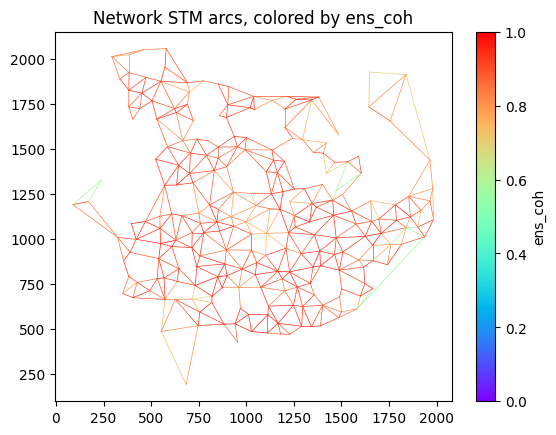

In [18]:
# x of sources and targets
xx = np.stack(
    [
        stm_pnts_output.isel(space=stm_arcs_output["source"])["range"].values,
        stm_pnts_output.isel(space=stm_arcs_output["target"])["range"].values,
    ]
).T
# y of sources and targets
yy = np.stack(
    [
        stm_pnts_output.isel(space=stm_arcs_output["source"])["azimuth"].values,
        stm_pnts_output.isel(space=stm_arcs_output["target"])["azimuth"].values,
    ]
).T
# Visualize created arcs
fig, ax = plt.subplots()
cmap = plt.cm.rainbow
norm = plc.Normalize(vmin=0, vmax=1.0)
mean_nmad = np.abs(stm_arcs_output["ens_coh"].data)
for i in range(stm_arcs_output.sizes["space"]):
    ax.plot(xx[i], yy[i], color=cmap(norm(mean_nmad[i])), linewidth=0.5)
plt.title("Network STM arcs, colored by ens_coh")
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="ens_coh")

In [19]:
assert stm_pnts_output.sizes["space"] == acheck.shape[0]

# Get radar coordinates of matlab results with idx_nonref_pnts
# idx_nonref_pnts is the points index of remaining non-reference points in matlab results w.r.t. original points
azimuth_matlab_results = azimuth_idx[idx_nonref_pnts]
range_matlab_results = range_idx[idx_nonref_pnts]

# Check if azimuth_matlab_results mononically increase
np.all(np.diff(azimuth_matlab_results) >= 0)

# select from stm_pnts_output with the radar coordinates in matlab results
idx_sel = []
for az, rg in zip(azimuth_matlab_results, range_matlab_results):
    mask = (stm_pnts_output["azimuth"] == az) * (stm_pnts_output["range"] == rg).values
    if mask.any():
        idx_sel.append(int(np.where(mask)[0][0]))
stm_pnts_output_filtered = stm_pnts_output.isel(space=idx_sel)
stm_pnts_output_filtered

<xarray.Dataset> Size: 2MB
Dimensions:      (space: 231, time: 359)
Coordinates:
  * space        (space) int64 2kB 3 8 9 10 11 12 13 ... 263 264 267 268 269 270
  * time         (time) float64 3kB -8.167 -8.137 -8.107 ... 5.877 5.907 5.937
    azimuth      (space) float64 2kB 192.0 426.0 471.0 ... 2.051e+03 2.058e+03
    range        (space) float64 2kB 684.0 954.0 1.229e+03 ... 384.0 460.0 579.0
Data variables:
    pnt_h2ph     (space, time) float64 663kB 0.001354 4.501e-05 ... -0.0002177
    pnt_phase    (space, time) float64 663kB -1.236 -2.07 ... -2.475 1.463
    ambiguities  (space, time) int16 166kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 -1 0 0

In [20]:
# select from stm_pnts_output with the radar coordinates in matlab results
idx_sel = []
for az, rg in zip(stm_pnts_output_filtered["azimuth"].values, stm_pnts_output_filtered["range"].values):
    mask = (azimuth_matlab_results == az) * (range_matlab_results == rg)
    if mask.any():
        idx_sel.append(int(np.where(mask)[0][0]))
azimuth_matlab_results_filtered = azimuth_matlab_results[idx_sel]
range_matlab_results_filtered = range_matlab_results[idx_sel]
acheck_filtered = acheck[idx_sel]

In [21]:
acheck_diff = stm_pnts_output_filtered["ambiguities"].values - acheck_filtered

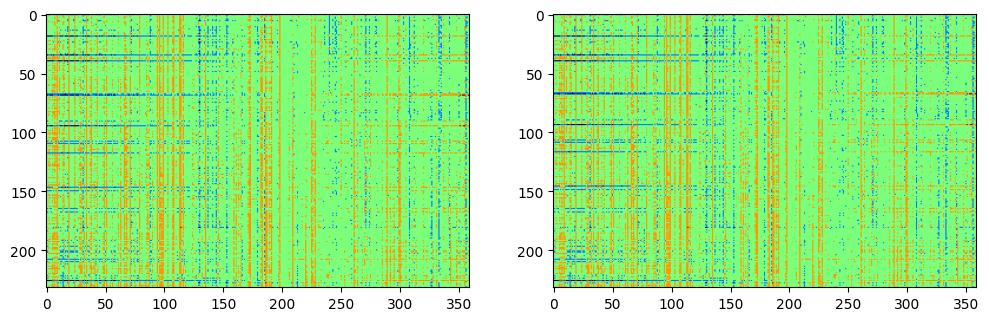

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(stm_pnts_output["ambiguities"].values, cmap="jet", vmin=-2, vmax=2)
ax[1].imshow(acheck, cmap="jet", vmin=-2, vmax=2)

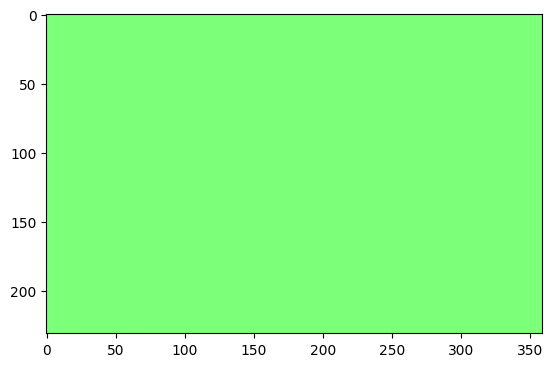

In [29]:
plt.imshow(acheck_diff, cmap="jet", vmin=-1e-10, vmax=1e-10)

## 